# ELO Merchant Category Recommendation - Exploratory Data Analysis

In [1]:
#packages to import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = pd.read_csv('data/train.csv').set_index('card_id')

print('Data shape: %s rows, %s columns\n' % (data.shape))
print('First few rows:\n')
print(data.head())
print('\nAny null values?\n')
print(data.isna().sum())

Data shape: 201917 rows, 5 columns

First few rows:

                first_active_month  feature_1  feature_2  feature_3    target
card_id                                                                      
C_ID_92a2005557            2017-06          5          2          1 -0.820283
C_ID_3d0044924f            2017-01          4          1          0  0.392913
C_ID_d639edf6cd            2016-08          2          2          0  0.688056
C_ID_186d6a6901            2017-09          4          3          0  0.142495
C_ID_cdbd2c0db2            2017-11          1          3          0 -0.159749

Any null values?

first_active_month    0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64


# Univariate Data Analysis

Features 1-3 are categorical variables with good distributions. No need to collapse categories and no risk of zero-variance predictors.

First active month distribution shows that it should be modeled as a numerical variable, and will be modeled as `antiquity` through the following algorithm:
* Convert `first_active_month` to dates.
* Apply the function $f(x) = \text{max}(x) - x$ where $x$ is the converted `first_active_month` variable.

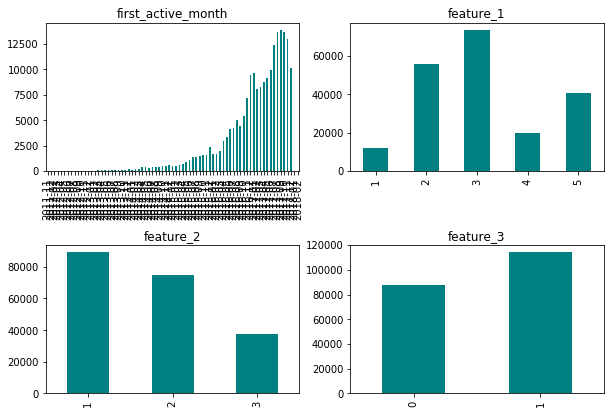

In [3]:
#Feature distribution
plt.figure(figsize=(10,15))
for i, feature in enumerate(data.columns[:-1]):
    plt.subplot(4,2,i+1)
    plt.title(feature)
    data[feature].value_counts().sort_index().plot(kind='bar', color='teal')
    plt.subplots_adjust(hspace=0.5)

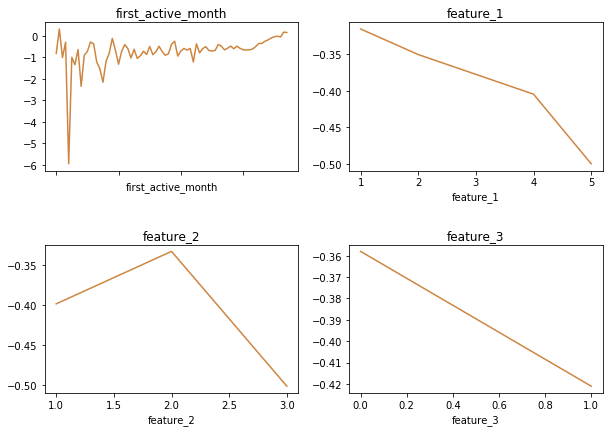

In [4]:
#Feature distribution wrt target
plt.figure(figsize=(10,15))
for i, feature in enumerate(data.columns[:-1]):
    plt.subplot(4,2,i+1)
    plt.title(feature)
    data.groupby(feature)['target'].mean().sort_index().plot(kind='line', color='peru')
    plt.subplots_adjust(hspace=0.5)

In [5]:
#Feature conversion
data['first_active_month'] = data['first_active_month'].apply(lambda x: datetime.strptime(x, '%Y-%m'))
max_date = data['first_active_month'].max()

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

data['antiquity'] = data['first_active_month'].apply(lambda x: diff_month(max_date, x))

In [6]:
#Resort and drop first active month
data = data.drop('first_active_month', axis=1)[['feature_1','feature_2','feature_3','antiquity','target']]
data.head()

,feature_1,feature_2,feature_3,antiquity,target
card_id,,,,,
C_ID_92a2005557,5,2,1,8,-0.820283
C_ID_3d0044924f,4,1,0,13,0.392913
C_ID_d639edf6cd,2,2,0,18,0.688056
C_ID_186d6a6901,4,3,0,5,0.142495
C_ID_cdbd2c0db2,1,3,0,3,-0.159749


In [7]:
#Perform one-hot-encoding, we'll check for correlations, dropping first of encodings
encoded_data = pd.get_dummies(data, columns=['feature_1','feature_2','feature_3'], drop_first=True)
encoded_data.head()

,antiquity,target,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1
card_id,,,,,,,,,
C_ID_92a2005557,8,-0.820283,0,0,0,1,1,0,1
C_ID_3d0044924f,13,0.392913,0,0,1,0,0,0,0
C_ID_d639edf6cd,18,0.688056,1,0,0,0,1,0,0
C_ID_186d6a6901,5,0.142495,0,0,1,0,0,1,0
C_ID_cdbd2c0db2,3,-0.159749,0,0,0,0,0,1,0


,antiquity,target,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_2,feature_2_3,feature_3_1
antiquity,1.000000,-0.050466,-0.112538,0.134804,-0.077987,0.080647,-0.013663,0.160787,0.196105
target,-0.050466,1.000000,0.006930,0.003166,-0.000946,-0.013848,0.012105,-0.013500,-0.008125
feature_1_2,-0.112538,0.006930,1.000000,-0.467867,-0.204239,-0.310128,0.086867,-0.103008,-0.705071
feature_1_3,0.134804,0.003166,-0.467867,1.000000,-0.250242,-0.379981,-0.060774,0.283753,0.663574
feature_1_4,-0.077987,-0.000946,-0.204239,-0.250242,1.000000,-0.165874,-0.015391,0.001783,-0.377113
feature_1_5,0.080647,-0.013848,-0.310128,-0.379981,-0.165874,1.000000,0.029150,-0.240998,0.439853
feature_2_2,-0.013663,0.012105,0.086867,-0.060774,-0.015391,0.029150,1.000000,-0.368513,-0.035429
feature_2_3,0.160787,-0.013500,-0.103008,0.283753,0.001783,-0.240998,-0.368513,1.000000,0.080580
feature_3_1,0.196105,-0.008125,-0.705071,0.663574,-0.377113,0.439853,-0.035429,0.080580,1.000000


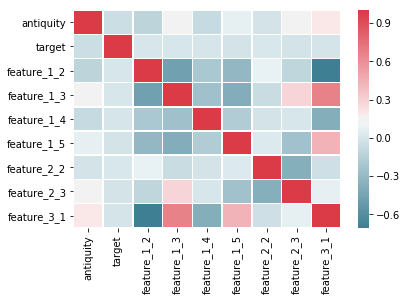

In [8]:
#check for correlations
corrs = encoded_data.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corrs, cmap=cmap, linewidths=.5)
corrs

# Baseline Model

For our baseline model we will try three traditional machine learning algorithms, fine-tune them and select the best one. We call it baseline because we are using only the base data set and not using any fancy feature engineering or deep-learning techniques.

The three models to be evaluated are:

* Elastic Net Regression
* Support Vector Machines
* Random Forest Regressor

We will define the following Pipeline for feature preprocessing:

* DateTransformer: perform the transforms made on the `first_active_month` column
* OneHotEncoding: perform the one-hot-encoding on the categorical features
* DropTransformer: drop unwanted columns
* Scaling: scales numerical columns to zero-mean and unit-variance

We will use the RMSE as our metric according to the Kaggle competition evaluation rules.

$$ \text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y_i})^2} $$

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

class DateTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, date_format='%Y-%m'):
        self.date_format = date_format
        
    def diff_month(self, d1, d2):
        return (d1.year - d2.year) * 12 + d1.month - d2.month
        
    def transform(self, X, y=None, **fit_params):
        print('\nPerforming date transforming...')
        dates = X.apply(lambda x: datetime.strptime(x, self.date_format))
        return pd.DataFrame(dates.apply(lambda x: self.diff_month(self.max_date, x)))
    
    def fit(self, X, y=None, **fit_params):
        dates = X.apply(lambda x: datetime.strptime(x, self.date_format))
        self.max_date = dates.max()
        return self
    
class DummyEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, categories='auto', sparse=True):
        self.categories = categories
        self.sparse = sparse

    def transform(self, X, y=None, **fit_params):
        print('\nEncoding dummy variables...')
        return self.ohe.transform(X)

    def fit(self, X, y=None, **fit_params):
        self.ohe = OneHotEncoder(sparse=self.sparse, categories=self.categories)
        self.ohe.fit(X)
        return self
    
class DropTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, cols_to_drop):
        assert isinstance(cols_to_drop, list)
        self.cols_to_drop = cols_to_drop
    
    def transform(self, X, y=None, **fit_params):
        print('\nDropping columns...')
        return np.delete(X, self.cols_to_drop, axis=1)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
#Read in raw data
data = pd.read_csv('data/train.csv').set_index('card_id')
print('Original data:')
print(data.head())

#Split data X, y
X = data.drop('target', axis=1)
y = data['target']

#Define processing pipeline
preprocessing = Pipeline([('ColumnTransformer', ColumnTransformer([('DateTransformer', DateTransformer(), 'first_active_month'),
                                                                   ('OneHotEncoder', DummyEncoder(categories='auto', sparse=False), ['feature_1', 'feature_2']),
                                                                   ('OrdinalEncoder', OrdinalEncoder(categories='auto'), ['feature_3'])], 
                                                                  remainder='passthrough')),
                          ('DropTransformer', DropTransformer(cols_to_drop=[1,6])),
                          ('Scaler', ColumnTransformer([('Scaler', StandardScaler(with_mean=True, with_std=True), [0])],
                                                      remainder='passthrough'))])

#Transform data using pipeline above
X = preprocessing.fit_transform(X)

print('\nTransformed data:')
print(X[:5])
print('\nTargets:')
print(y[:5])

Original data:
                first_active_month  feature_1  feature_2  feature_3    target
card_id                                                                      
C_ID_92a2005557            2017-06          5          2          1 -0.820283
C_ID_3d0044924f            2017-01          4          1          0  0.392913
C_ID_d639edf6cd            2016-08          2          2          0  0.688056
C_ID_186d6a6901            2017-09          4          3          0  0.142495
C_ID_cdbd2c0db2            2017-11          1          3          0 -0.159749

Performing date transforming...

Encoding dummy variables...

Dropping columns...

Transformed data:
[[-0.46748063  0.          0.          0.          1.          1.
   0.          1.        ]
 [ 0.05082796  0.          0.          1.          0.          0.
   0.          0.        ]
 [ 0.56913655  1.          0.          0.          0.          1.
   0.          0.        ]
 [-0.77846579  0.          0.          1.          0.     

In [3]:
#Train/Test splitting, definition of scoring callable, and importing of Hyperparameter tuning and model persistence libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from joblib import dump

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000)

def rmse(y, y_pred, **kwargs):
    return np.sqrt(mean_squared_error(y, y_pred))

rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)

In [5]:
#Elastic Net
from sklearn.linear_model import ElasticNet

enet_grid = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
             'l1_ratio':np.arange(0, 1, 0.1)}

enet = ElasticNet()

enet_cv = RandomizedSearchCV(estimator=enet, 
                             param_distributions=enet_grid, 
                             n_iter=10, 
                             scoring=rmse_scorer, 
                             n_jobs=-1, 
                             cv=5,
                             random_state=42,
                             verbose=2)

enet_cv.fit(X_train, y_train)
dump(enet_cv, 'models/enet.joblib')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.7min finished


['models/enet.joblib']

In [ ]:
#Support Vector Regressor
from sklearn.svm import SVR

svr_grid = {'kernel':['linear','poly','rbf','sigmoid'],
            'C':[0.001, 0.01, 0.1, 1, 10],
            'gamma':[0.001, 0.01, 0.1, 1]}

svr = SVR()

svr_cv = RandomizedSearchCV(estimator=svr, 
                            param_distributions=svr_grid, 
                            n_iter=10, 
                            scoring=rmse_scorer, 
                            n_jobs=-1, 
                            cv=5,
                            random_state=42,
                            verbose=2)

svr_cv.fit(X_train, y_train)
dump(svr_cv, 'models/svr.joblib')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_grid = {'max_depth': np.arange(5, 100, 5),
           'max_features': ['auto', 'sqrt'],
           'min_samples_leaf': [1, 10, 50, 100],
           'min_samples_split': [2, 10, 100, 200],
           'n_estimators': np.arange(250, 2000, 250)}

rf = RandomForestRegressor()

rf_cv = RandomizedSearchCV(estimator=rf, 
                           param_distributions=rf_grid, 
                           n_iter=10, 
                           scoring=rmse_scorer, 
                           n_jobs=-1, 
                           cv=5,
                           random_state=42,
                           verbose=2)

rf_cv.fit(X_train, y_train)
dump(rf_cv, 'models/rf.joblib')

In [ ]:
#Load models, if necessary
from joblib import load

load('models/enet.joblib')
load('models/svr.joblib')
load('models/rf.joblib')

In [20]:
models = [('Elastic Net', enet_cv.best_estimator_),
          ('Support Vector Machine', svr_cv.best_estimator_),
          ('Random Forest', rf_cv.best_estimator_)]

for model in models:
    label, estimator = model
    y_pred = estimator.predict(X_test)
    print('|{label} | RMSE on training set = {rmse}|'.format(label=label, rmse=round(rmse(y_test, y_pred), 3)))

NameError: name 'svr_cv' is not defined